# SOTA Approach for Solving Lyapunov Function

## Setup 

In [99]:
import torch
import numpy as np
import timeit
import matplotlib.pyplot as plt
import math
import sympy as sym
from numpy import random
import torch.nn.functional as F
import sympy as sym
from sympy import lambdify
from dreal import *
from mpl_toolkits import mplot3d
%matplotlib inline

## Helper function used for training

In [100]:
# Helper Function

from dreal import *
import torch 
import numpy as np
import random


def CheckLyapunov(x, f, V, ball_lb, ball_ub, config, epsilon):    
    # Given a dynamical system dx/dt = f(x,u) and candidate Lyapunov function V
    # Check the Lyapunov conditions within a domain around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub). 
    # If it return unsat, then there is no state violating the conditions. 
    
    ball= Expression(0)
    lie_derivative_of_V = Expression(0)
    
    for i in range(len(x)):
        ball += x[i]*x[i]
        lie_derivative_of_V += f[i]*V.Differentiate(x[i])  
    ball_in_bound = logical_and(ball_lb*ball_lb <= ball, ball <= ball_ub*ball_ub)
    
    # Constraint: x ∈ Ball → (V(c, x) > 0 ∧ Lie derivative of V <= 0)     
    condition = logical_and(logical_imply(ball_in_bound, V >= 0),
                           logical_imply(ball_in_bound, lie_derivative_of_V <= epsilon))
    return CheckSatisfiability(logical_not(condition),config)

def AddCounterexamples(x,CE,N): 
    # Adding CE back to sample set
    c = []
    nearby= []
    for i in range(CE.size()):
        c.append(CE[i].mid())
        lb = CE[i].lb()
        ub = CE[i].ub()
        nearby_ = np.random.uniform(lb,ub,N)
        nearby.append(nearby_)
    for i in range(N):
        n_pt = []
        for j in range(x.shape[1]):
            n_pt.append(nearby[j][i])             
        x = torch.cat((x, torch.tensor([n_pt])), 0)
    return x
  
def dtanh(s):
    # Derivative of activation
    return 1.0 - s**2

def Tune(x):
    # Circle function values
    y = []
    for r in range(0,len(x)):
        v = 0 
        for j in range(x.shape[1]):
            v += x[r][j]**2
        f = [torch.sqrt(v)]
        y.append(f)
    y = torch.tensor(y)
    return y

## Neural Network

In [101]:
class Net(torch.nn.Module):

    def __init__(self,n_input,n_hidden,n_output,lqr):
        super(Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)
        self.control = torch.nn.Linear(n_input,1,bias=False)
        self.control.weight = torch.nn.Parameter(lqr)

    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        u = self.control(x)
        return out,u


## Dynamics Setup

In [102]:
def f_value(x,u):
    #Dynamics
    y = []
    G = 9.81  # gravity
    L = 0.5   # length of the pole
    m = 0.15  # ball mass
    b = 0.1   # friction

    for r in range(0,len(x)):
        f = [ x[r][1],
              (m*G*L*np.sin(x[r][0])- b*x[r][1]) / (m*L**2)]
        y.append(f)
    y = torch.tensor(y)
    y[:,1] = y[:,1] + (u[:,0]/(m*L**2))
    return y

## Data Preparation for Training

In [103]:
'''
For learning
'''
N = 500             # sample size
D_in = 2            # input dimension
H1 = 6              # hidden dimension
D_out = 1           # output dimension
torch.manual_seed(10)
x = torch.Tensor(N, D_in).uniform_(-6, 6).to(torch.double)
x_0 = torch.zeros([1, 2]).to(torch.double)

'''
For verifying
'''
x1 = Variable("x1")
x2 = Variable("x2")
vars_ = [x1,x2]
G = 9.81
l = 0.5
m = 0.15
b = 0.1
config = Config()
config.use_polytope_in_forall = True
config.use_local_optimization = True
config.precision = 1e-2
epsilon = 0
# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 0.5
ball_ub = 6

## Training

In [104]:
out_iters = 0
valid = False
while out_iters < 2 and not valid:
    start = timeit.default_timer()
    lqr = torch.tensor([[-23.58639732,  -5.31421063]]).to(torch.double)  # lqr solution
    model = Net(D_in,H1, D_out,lqr).double()
    L = []
    i = 0
    t = 0
    max_iters = 2000
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    while i < max_iters and not valid:
        V_candidate, u = model(x)
        X0,u0 = model(x_0)
        f = f_value(x,u)
        Circle_Tuning = Tune(x)
        # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model.layer1.weight.t().to(torch.double))+model.layer1.bias.to(torch.double))),model.layer1.weight.to(torch.double)),f.t().to(torch.double)),0)

        # With tuning term
        Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.5)).mean() + 2.2*((Circle_Tuning-6*V_candidate).pow(2)).mean()+(X0).pow(2)
        # Without tuning term
        # Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.1)).mean()+ 1.2*(X0).pow(2)


        print(i, "Lyapunov Risk=",Lyapunov_risk.item())
        L.append(Lyapunov_risk.item())
        optimizer.zero_grad()
        Lyapunov_risk.backward()
        optimizer.step()

        w1 = model.layer1.weight.data.numpy()
        w2 = model.layer2.weight.data.numpy()
        b1 = model.layer1.bias.data.numpy()
        b2 = model.layer2.bias.data.numpy()
        q = model.control.weight.data.numpy()

        # Falsification
        if i % 10 == 0:
            u_NN = (q.item(0)*x1 + q.item(1)*x2)
            f = [ x2,
                 (m*G*l*sin(x1) + u_NN - b*x2) /(m*l**2)]

            # Candidate V
            z1 = np.dot(vars_,w1.T)+b1

            a1 = []
            for j in range(0,len(z1)):
                a1.append(tanh(z1[j]))
            z2 = np.dot(a1,w2.T)+b2
            V_learn = tanh(z2.item(0))

            print('===========Verifying==========')
            start_ = timeit.default_timer()
            result= CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config,epsilon)
            stop_ = timeit.default_timer()

            if (result):
                print("Not a Lyapunov function. Found counterexample: ")
                print(result)
                x = AddCounterexamples(x,result,10)
            else:
                valid = True
                print("Satisfy conditions!!")
                print(V_learn, " is a Lyapunov function.")
            t += (stop_ - start_)
            print('==============================')
        i += 1

    stop = timeit.default_timer()


    np.savetxt("w1.txt", model.layer1.weight.data, fmt="%s")
    np.savetxt("w2.txt", model.layer2.weight.data, fmt="%s")
    np.savetxt("b1.txt", model.layer1.bias.data, fmt="%s")
    np.savetxt("b2.txt", model.layer2.bias.data, fmt="%s")
    np.savetxt("q.txt", model.control.weight.data, fmt="%s")

    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)

    out_iters+=1

0 Lyapunov Risk= 73.07649902805298
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-5.6079814006448672, -5.6073700726100384]
x2 : [0.97427857925749373, 0.97459572723251242]
1 Lyapunov Risk= 60.25016067452956
2 Lyapunov Risk= 53.66996371331378
3 Lyapunov Risk= 49.372581457970426
4 Lyapunov Risk= 44.90864709709004
5 Lyapunov Risk= 40.79866793927275
6 Lyapunov Risk= 37.15639457636228
7 Lyapunov Risk= 33.953127448405546
8 Lyapunov Risk= 31.183676438019614
9 Lyapunov Risk= 28.75726333635544
10 Lyapunov Risk= 26.62336026164306
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.2046583067225474, -0.19465830672254739]
x2 : [0.51139975191434661, 0.52139975191434662]
11 Lyapunov Risk= 24.496982724689726
12 Lyapunov Risk= 23.260030954093985
13 Lyapunov Risk= 22.129892438776267
14 Lyapunov Risk= 20.74156140781095
15 Lyapunov Risk= 19.273544492213286
16 Lyapunov Risk= 18.058150808574084
17 Lyapunov Risk= 17.4666782248719
18 L

## Result Validation

In [8]:
epsilon = -0.00001
start_ = timeit.default_timer() 
result = CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config, epsilon)
stop_ = timeit.default_timer() 

if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
else:  
    print("Satisfy conditions with epsilon= ",epsilon)
    print(V_learn, " is a Lyapunov function.")
t += (stop_ - start_)

Satisfy conditions with epsilon=  -1e-05
tanh((0.47141653066031153 + 0.27146761812980347 * tanh((-1.0132680146692099 - 0.66422895984027841 * x1 - 0.29893553470066098 * x2)) + 0.85837488543099616 * tanh((-0.76322033924622112 + 0.64214915022460806 * x1 + 0.051282612747506805 * x2)) - 0.42612059289448434 * tanh((-0.75829542051209653 - 0.049712370647002561 * x1 + 0.008060721797728005 * x2)) - 0.77066406107859309 * tanh((1.003764216150473 + 0.92362532188110624 * x1 - 0.0098690011046191125 * x2)) + 1.0139386329828859 * tanh((1.1212264335939603 + 0.028437338554132253 * x1 - 0.0023876738186623964 * x2)) - 0.069159840047195761 * tanh((1.2462201394419461 - 0.17835804259005614 * x1 - 0.40082642448475053 * x2))))  is a Lyapunov function.


## Visualization

### Visualization of Lyapunov Function

In [9]:
x = np.linspace(-6, 6, 300)
y = np.linspace(-6, 6, 300)
X, Y = np.meshgrid(x, y)

Z = []
for i in range(300):
    temp = []
    for j in range(300):
        input = torch.tensor([x[j], y[i]]).to(torch.double)
        result = model(input)
        temp.append(result[0].detach().numpy()[0])
    Z.append(temp)
Z = np.array(Z)
len(Z), len(Z[0])

(300, 300)

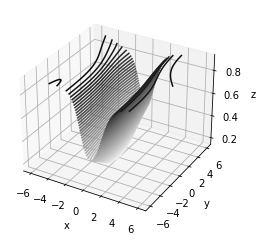

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 40, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Text(0.5, 0, 'Function Value')

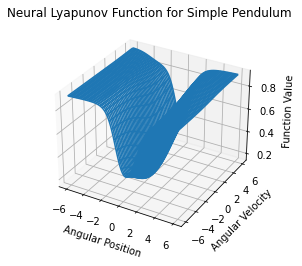

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z)
ax.set_title('Neural Lyapunov Function for Simple Pendulum ')
ax.set_xlabel('Angular Position')
ax.set_ylabel('Angular Velocity')
ax.set_zlabel('Function Value')